<a href="https://colab.research.google.com/github/BautistaDavid/Proyectos_ClaseML/blob/corte_1/proyecto4_Regresion_multiple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wooldridge

## **Proyecto 4 - Objeto Regresión**
En el proyecto se busca crear un objeto que permita ejecutar una Regresion Lineal Multiple para unas variables de la base de datos ```crime1``` de wooldridge

 

#### **Importamos datos**

Importamos la base de datos ```crime1``` usando el moudlo  ```wooldridge```, además podemos acceder a información general sobre las variables. Asi mismo se puede plotear un heatmap para revisar posibles problemas de multicolinealidad en los moedlos que se van a correr.

In [84]:
import wooldridge as wd 
wd.data("crime1",description=True)
datos_crimen = wd.data("crime1")
datos_crimen.head(3)

name of dataset: crime1
no of variables: 16
no of observations: 2725

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| narr86   | # times arrested, 1986          |
| nfarr86  | # felony arrests, 1986          |
| nparr86  | # property crme arr., 1986      |
| pcnv     | proportion of prior convictions |
| avgsen   | avg sentence length, mos.       |
| tottime  | time in prison since 18 (mos.)  |
| ptime86  | mos. in prison during 1986      |
| qemp86   | # quarters employed, 1986       |
| inc86    | legal income, 1986, $100s       |
| durat    | recent unemp duration           |
| black    | =1 if black                     |
| hispan   | =1 if Hispanic                  |
| born60   | =1 if born in 1960              |
| pcnvsq   | pcnv^2                          |
| pt86sq   | ptime86^2                       |
| inc86sq  | inc86^2                         |
+----------+-------------------------

,narr86,nfarr86,nparr86,pcnv,avgsen,tottime,ptime86,qemp86,inc86,durat,black,hispan,born60,pcnvsq,pt86sq,inc86sq
0,0,0,0,0.38,17.600000,35.200001,12,0.0,0.0,0.0,0,0,1,0.1444,144,0.00
1,2,2,0,0.44,0.000000,0.000000,0,1.0,0.8,0.0,0,1,0,0.1936,0,0.64
2,1,1,0,0.33,22.799999,22.799999,0,0.0,0.0,11.0,1,0,1,0.1089,0,0.00


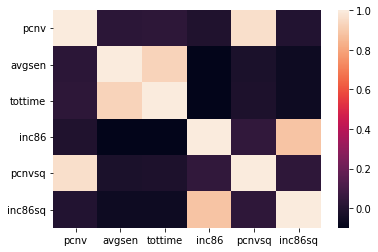

In [92]:
import seaborn as sns 
sns.heatmap(datos_crimen[["pcnv","avgsen","tottime","inc86","pcnvsq","inc86sq"]].corr())  

#### **Construcción Objeto**

El objeto tiene metodos ocultos para formar la tablas de resultdos y la información de la Anova. Asi mismo esta el metodo ```fit``` con el que se pretendia de cierta manera inicializar los calculos de la regresión. (Al final del Notebook se deja el codigo de una nueva versión en la que se esta trabajando para poder establecer al metodo ```fit``` como un "inicializador" de la regresión). Por ultimo el metodo ```summary()``` permite acceder a un resumen de la información obtenida en la regresión.

Hay ciertas opciones que se craron para la clase, se puede establecer si se desea que la regresión trabaje con una constante y asi mismo se puede fijar un nivel de significancia para el calculo de los intervalos de confianza.



In [94]:
import numpy as np 
import pandas as pd 
import scipy.stats as sst
from scipy import stats

class Lineal_Reg(object):
  def __init__(self,Y,X,alpha=0.05,intercepto = True):
    self.__intercepto = intercepto
    self.Y = Y.to_numpy().reshape(len(Y),1)
    if self.__intercepto == True: 
      self.X = np.c_[np.ones(self.Y.shape[0]),X.to_numpy()] if len(X.shape) !=1 else np.c_[np.ones(len(X)),X.to_numpy().reshape([len(X),1])]     
    elif self.__intercepto == False: 
      self.X = X.to_numpy() if len(X.shape) !=1 else X.to_numpy().reshape([len(X),1])

    self.__alpha = alpha
    self.__names = X.columns if len(X.shape)!=1 else [X.name]
    self.n = self.X.shape[0]
    self.k = self.X.shape[1] -1 if len(X.shape) !=1 else 1
    self.gl = self.n - self.k -1


  def fit(self):
    self.betas = (np.linalg.inv(self.X.T@self.X)@self.X.T@self.Y)
 
  
  def __anova(self):
    self.fit()
    self.residuos = self.Y - (self.X @ self.betas)
    self.SEC = np.sum(np.square(self.X @ self.betas -np.mean(self.Y)))
    self.SRC = np.sum(np.square(self.residuos))
    self.STC = np.sum(np.square(self.Y-np.mean(self.Y)))
    self.R_2 = 1-self.SRC/self.STC
    self.estadistico_F = (self.R_2 / self.k) / ((1-self.R_2)/(self.n - self.k -1))
    self.MS_model = self.SEC / self.k    #desviaciones media 
    self.MS_residual = self.SRC / self.gl 
    self.MS_total = self.STC / (self.n - 1)

  def __tabla_resultados(self):
    self.fit()
    self.m_covarianzas = (self.SRC/self.gl) * (np.linalg.inv(self.X.T @ self.X))
    self.varianzas = np.diag(self.m_covarianzas)
    self.errores_estandar = np.sqrt(self.varianzas).ravel().tolist() # ya quedo en lista
    self.t_values = [betas/errores for (betas,errores) in zip(self.betas.ravel().tolist(),self.errores_estandar)]
    self.p_values = [stats.t.sf(np.abs(t_val), self.n-1)*2 for t_val in self.t_values]  #t,Gl
    #intervalos 
    self.t_level = sst.t.ppf(1 - self.__alpha/2, df=self.n - self.k - 1 )  # df = n-k-1
    self.intervalos = [sorted([beta - (errcoef * self.t_level),beta + (errcoef * self.t_level)]) for (beta,errcoef) in zip(self.betas.ravel().tolist(),self.errores_estandar)]
  
  @property  # Decorador para transfromar metodo en atributo
  def summary(self):
    self.__anova()
    self.__tabla_resultados()
    panel = pd.DataFrame(index=["Modelo","Residual","Total"])
    panel["SS"] = [self.SEC,self.SRC,self.STC]
    panel["df"] = [self.k,self.gl,self.n-1]
    panel["MS"] = [self.MS_model,self.MS_residual,self.MS_total]
    panel["  "] = ["   ","   ","   "]
    panel["    "] = [f"No. Observaciones = {self.n}",f"F{self.k,self.gl} = {round(self.estadistico_F,2)}",f"R-cuadrado = {round(self.R_2,4)}"]   # Esto toca organizarlo mejor  
   
    resultados=pd.DataFrame(index= ["_Cons"]+ [i for i in self.__names]) if self.__intercepto == True else pd.DataFrame(index= [i for i in self.__names])
    resultados["Coeficientes"] = [round(i,4) for i in self.betas.ravel().tolist()]
    resultados["E.Estandar"] = self.errores_estandar
    resultados["t"] = [round(i,2) for i in self.t_values]
    resultados["P"] = [round(i,4) for i in self.p_values] 
    resultados["Intervalos de confianza"] = [(round(i[0],6),round(i[1],6)) for i in self.intervalos]
    print(panel)
    print()
    print(resultados)

#### **Probamos las clase...**

In [95]:
Y = datos_crimen["narr86"]
X = datos_crimen[["pcnv","avgsen","tottime","inc86"]]
my_reg = Lineal_Reg(Y,X) 
my_reg.summary

                   SS    df         MS                               
Modelo      84.423332     4  21.105833       No. Observaciones = 2725
Residual  1925.923824  2720   0.708060             F(4, 2720) = 29.81
Total     2010.347156  2724   0.738013             R-cuadrado = 0.042

         Coeficientes  E.Estandar      t       P Intervalos de confianza
_Cons          0.5939    0.025858  22.97  0.0000    (0.543172, 0.644578)
pcnv          -0.1624    0.040816  -3.98  0.0001  (-0.242471, -0.082403)
avgsen        -0.0062    0.012381  -0.50  0.6172   (-0.030465, 0.018089)
tottime        0.0077    0.009432   0.82  0.4137   (-0.010784, 0.026205)
inc86         -0.0024    0.000243 -10.02  0.0000  (-0.002913, -0.001959)


Modelo especificado:

$$inc86 = B_0+B_1pcnv+B_2avgsen+B_3tottime+B_4inc86$$

Se puede comentar el hecho de que dentro de la regresión las variables ```pcnv``` y ```inc86``` son las unicas estadisticamente significativas bajo el modelo espicificado. De manera que el modelo estima que un aumento de una unidad en la proprsión de condenas anteriores estaria asociado con una disminución de 0.16 numero de arrestos, sin tener en cuenta la magnitud en este caso puede resultar interesante como tal el signo de esta misma. Por otro lado un aumento de 100 dolares en los ingresos legales de un individuo durante el año 86 estaria asociado a una disminucion de 0.0024 condenas, Otra vez, es mas interesante analizar el signo del estimador que la magnitud. 

Por otro lado tambien se puede comentar que las variables en conjunto no logran explicar apenas el 4.2 % de la variabilidad de las veces que fue arrestado un indiduo en el 86. Aun asi ouede que el modelo permite realizar predicciones, las cuales tendrian que ser evaluadas por metricas distintas.

In [96]:
Y = datos_crimen["narr86"]
X = datos_crimen[["pcnv","avgsen","tottime","inc86","pcnvsq","inc86sq"]]
my_reg = Lineal_Reg(Y,X) 
my_reg.summary

                   SS    df         MS                               
Modelo     117.455739     6  19.575957       No. Observaciones = 2725
Residual  1892.891417  2718   0.696428             F(6, 2718) = 28.11
Total     2010.347156  2724   0.738013            R-cuadrado = 0.0584

         Coeficientes  E.Estandar      t       P Intervalos de confianza
_Cons          0.5775    0.029933  19.29  0.0000    (0.518829, 0.636218)
pcnv           0.6226    0.154837   4.02  0.0001    (0.319024, 0.926245)
avgsen        -0.0069    0.012280  -0.56  0.5728   (-0.031005, 0.017154)
tottime        0.0045    0.009366   0.48  0.6318   (-0.013877, 0.022854)
inc86         -0.0041    0.000530  -7.70  0.0000  (-0.005119, -0.003042)
pcnvsq        -0.8266    0.156661  -5.28  0.0000  (-1.133775, -0.519402)
inc86sq        0.0000    0.000002   4.02  0.0001        (4e-06, 1.3e-05)


Planteando ahora el modelo con variables adicionales de forma cuadrática podemos ver que las mismas variables que en el primer modelo no eran significativas se mantienen así, por otro lado los signos de las variables con una forma funcional cuadrática nos indican cierto tipo de relación no lineal con respecto a la dependiente. 

#### Pruevba extra de modificaicón a la clase 

In [97]:
import numpy as np 
import pandas as pd 
import scipy.stats as sst
from scipy import stats

class Lineal_Reg(object):
  def __init__(self,Y,X,alpha=0.05,intercepto = True):
    self.intercepto = intercepto
    self.Y = Y.to_numpy().reshape(len(Y),1)
    if self.intercepto == True: 
      self.X = np.c_[np.ones(self.Y.shape[0]),X.to_numpy()] if len(X.shape) !=1 else np.c_[np.ones(len(X)),X.to_numpy().reshape([len(X),1])]     
    elif self.intercepto == False: 
      self.X = X.to_numpy() if len(X.shape) !=1 else X.to_numpy().reshape([len(X),1])

    self.alpha = alpha
    self.names = X.columns if len(X.shape)!=1 else [X.name]
    self.n = self.X.shape[0]
    self.k = self.X.shape[1] -1 if len(X.shape) !=1 else 1
    self.gl = self.n - self.k -1
  
  class fit():
    def __init__(self):
      Lineal_Reg.__init__(self,Y,X,alpha=0.05,intercepto = True)
      self.betas = (np.linalg.inv(self.X.T@self.X)@self.X.T@self.Y)
  
    def __anova(self):
      self.residuos = self.Y - (self.X @ self.betas)
      self.SEC = np.sum(np.square(self.X @ self.betas -np.mean(self.Y)))
      self.SRC = np.sum(np.square(self.residuos))
      self.STC = np.sum(np.square(self.Y-np.mean(self.Y)))
      self.R_2 = 1-self.SRC/self.STC
      self.estadistico_F = (self.R_2 / self.k) / ((1-self.R_2)/(self.n - self.k -1))
      self.MS_model = self.SEC / self.k    #desviaciones media 
      self.MS_residual = self.SRC / self.gl 
      self.MS_total = self.STC / (self.n - 1)

    def __tabla_resultados(self):
      self.m_covarianzas = (self.SRC/self.gl) * (np.linalg.inv(self.X.T @ self.X))
      self.varianzas = np.diag(self.m_covarianzas)
      self.errores_estandar = np.sqrt(self.varianzas).ravel().tolist() # ya quedo en lista
      self.t_values = [betas/errores for (betas,errores) in zip(self.betas.ravel().tolist(),self.errores_estandar)]
      self.p_values = [stats.t.sf(np.abs(t_val), self.n-1)*2 for t_val in self.t_values]  #t,Gl
    #intervalos 
      self.t_level = sst.t.ppf(1 - self.alpha/2, df=self.n - self.k - 1 )  # df = n-k-1
      self.intervalos = [sorted([beta - (errcoef * self.t_level),beta + (errcoef * self.t_level)]) for (beta,errcoef) in zip(self.betas.ravel().tolist(),self.errores_estandar)]
  
  # daad @property 
    def summary(self):
      self.__anova()
      self.__tabla_resultados()
      panel = pd.DataFrame(index=["Modelo","Residual","Total"])
      panel["SS"] = [self.SEC,self.SRC,self.STC]
      panel["df"] = [self.k,self.gl,self.n-1]
      panel["MS"] = [self.MS_model,self.MS_residual,self.MS_total]
      panel["  "] = ["   ","   ","   "]
      panel["    "] = [f"No. Observaciones = {self.n}",f"F{self.k,self.gl} = {round(self.estadistico_F,2)}",f"R-cuadrado = {round(self.R_2,4)}"]   # Esto toca organizarlo mejor  
   
      resultados=pd.DataFrame(index= ["_Cons"]+ [i for i in self.names]) if self.intercepto == True else pd.DataFrame(index= [i for i in self.__names])
      resultados["Coeficientes"] = [round(i,4) for i in self.betas.ravel().tolist()]
      resultados["E.Estandar"] = self.errores_estandar
      resultados["t"] = [round(i,2) for i in self.t_values]
      resultados["P"] = [round(i,4) for i in self.p_values] 
      resultados["Intervalos de confianza"] = [(round(i[0],6),round(i[1],6)) for i in self.intervalos]
      print(panel)
      print()
      print(resultados)

In [98]:
import wooldridge as wd 

datos_crimen = wd.data("crime1")
datos_crimen.head(3)
Y = datos_crimen["narr86"]
X = datos_crimen[["pcnv","avgsen","tottime","inc86"]]
modelo = Lineal_Reg(Y,X,alpha=0.05)
reg =modelo.fit()
reg.summary()    


                   SS    df         MS                               
Modelo      84.423332     4  21.105833       No. Observaciones = 2725
Residual  1925.923824  2720   0.708060             F(4, 2720) = 29.81
Total     2010.347156  2724   0.738013             R-cuadrado = 0.042

         Coeficientes  E.Estandar      t       P Intervalos de confianza
_Cons          0.5939    0.025858  22.97  0.0000    (0.543172, 0.644578)
pcnv          -0.1624    0.040816  -3.98  0.0001  (-0.242471, -0.082403)
avgsen        -0.0062    0.012381  -0.50  0.6172   (-0.030465, 0.018089)
tottime        0.0077    0.009432   0.82  0.4137   (-0.010784, 0.026205)
inc86         -0.0024    0.000243 -10.02  0.0000  (-0.002913, -0.001959)
